The goal is to use the full vertical structure of temperature and moisture as predictors. For starters, we can just use the ERA-5 pressure level data. 

In [1]:
import os
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import matplotlib
import datetime as dt
import xarray as xr

In [74]:
date=dt.datetime(2016,1,1)

fil='/neelin2020/ERA-5_Tq_ps/hourly/npz_files/Tq_prc_matched_{}.npz'.format(date.strftime("%Y_%m_%d"))
f=np.load(fil,'r')
prc_ocn=f['prc_ocn']
T_ocn=f['T_ocn'].T  # have time variable first
q_ocn=f['q_ocn'].T
f.close()

In [75]:
fil1='/neelin2020/ML_input/era5_condensed_thermo1_{}.npz'.format(date.strftime("%Y_%m_%d"))
f=np.load(fil1,'r')
crh_ocn=f['crh_ocn']

In [76]:
ds_era5_lev=xr.open_dataset('/home/fiaz/ML/precip_mapping/files/era5_levels.nc')
lev=ds_era5_lev.lev.values


In [77]:
lev_indx=16
T_ocn_trunc=T_ocn[:,lev_indx:]
q_ocn_trunc=q_ocn[:,lev_indx:]

In [134]:
# path='/home/fiaz/ML/saved_models/NN_6layers_500hPa_UT_vert_Tq.pth'
# path='/home/fiaz/ML/saved_models/NN_6layers_500hPa_vert_Tq.pth'
path='/home/fiaz/ML/saved_models/NN_6layers_full_vert_Tq.pth'


### Prep. data

In [78]:
## randomize data
ind_random=np.arange(prc_ocn.size)
np.random.shuffle(ind_random)

In [79]:
def randomize_split(data,data_dict,indx_random,
                    p=10,idx_sub=500000):
    
    '''
    Takes a single dimensional array data and randomized
    indices indx_random. Splits data into training, test and validation
    datasets. Test and validation data are p percent of the data
    '''
    
    data_randomized=data[indx_random]
    
    idx=int(p*1e-2*data.shape[0])
    idx_train=int(data.shape[0]*(100-2*p)*1e-2)
    
    if idx_sub:
        data_train=data_randomized[:idx_sub]
    else:
        data_train=data_randomized[:idx_train]
    
    data_validate=data_randomized[idx_train:idx_train+idx]
    data_test=data_randomized[idx_train+idx:]
    
    data_dict['train'],data_dict['validate'],data_dict['test']=data_train,data_validate,data_test
    

In [110]:
prc={}
randomize_split(prc_ocn,prc,ind_random)
Temp={}
randomize_split(T_ocn,Temp,ind_random)
sphum={}
randomize_split(q_ocn,sphum,ind_random)

### Normalize data. 
  Use 2*prc_max for precip and std dev. for q and T

In [111]:
#Declare constants
LV=2260e3
CP=1006.

In [112]:
def normalize_data(data_dict,data_norm_dict,
                   xbar,normalizer):
    for key in data_dict.keys():
        data_norm_dict[key]=(data_dict[key]-xbar)/normalizer
    data_norm_dict['xbar']=xbar
    data_norm_dict['normalizer']=normalizer


In [113]:
prc_norm={}
normalize_data(prc,prc_norm,0,
               2*prc['train'].max())

In [114]:
sphum_norm={}
normalize_data(sphum,sphum_norm,sphum['train'].mean(axis=0)[None,:],
               sphum['train'].std(axis=0)[None,:])

Temp_norm={}
normalize_data(Temp,Temp_norm,Temp['train'].mean(axis=0)[None,:],
               Temp['train'].std(axis=0)[None,:])


27

### Create data loader 


In [115]:
### dimension zero of the input tensors must match
x=np.hstack((sphum_norm['train'],Temp_norm['train'])) ### stack along height dimension
train_data=torch.utils.data.TensorDataset(torch.from_numpy(x).float().unsqueeze(2),
                                          torch.from_numpy(prc_norm['train']).float().unsqueeze(1))

x=np.hstack((sphum_norm['validate'],Temp_norm['validate']))
val_data=torch.utils.data.TensorDataset(torch.from_numpy(x).float().unsqueeze(2),
                                          torch.from_numpy(prc_norm['validate']).float().unsqueeze(1))

In [116]:
#create training datasets
training_loader=torch.utils.data.DataLoader(train_data, batch_size=256, shuffle=False, 
                                            num_workers=0)
val_loader=torch.utils.data.DataLoader(val_data, batch_size=256, shuffle=False, num_workers=0)
print('Training set has {} instances'.format(len(train_data.tensors[0])))
print('Validation set has {} instances'.format(len(val_data.tensors[0])))

Training set has 500000 instances
Validation set has 362004 instances


### Build NN architecture 


In [135]:
class NeuralNetwork_2D(nn.Module):
    def __init__(self, LEV_DIM):
        super(NeuralNetwork_2D,self).__init__() ## initialize the super class
        
        self.flatten=nn.Flatten()
        self.layer1=nn.Linear(LEV_DIM*2,256)
        self.layer2=nn.Linear(256,256)
#         self.layer2=nn.Linear(216,532)
        self.layer3=nn.Linear(256,256)
        self.layer4=nn.Linear(256,256)
        self.layer5=nn.Linear(256,256)
        self.layer6=nn.Linear(256,1)
#         self.layer7=nn.Linear(256,1)
        self.dropout = nn.Dropout(0.25)
        
    def forward(self,x):
        x=self.flatten(x)
        x=torch.relu(self.layer1(x))
        x=self.dropout(x)
        x=torch.relu(self.layer2(x))
        x=self.dropout(x)
        x=torch.relu(self.layer3(x))
        x=torch.relu(self.layer4(x))
        x=torch.relu(self.layer5(x))
#         x=torch.relu(self.layer6(x))
        x=torch.sigmoid(self.layer6(x))
#         x=torch.relu(self.layer3(x))
        
        return x

LEV_DIM=Temp_norm['train'].shape[1]
model=NeuralNetwork_2D(LEV_DIM).to(device)

In [136]:
model

NeuralNetwork_2D(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer1): Linear(in_features=54, out_features=256, bias=True)
  (layer2): Linear(in_features=256, out_features=256, bias=True)
  (layer3): Linear(in_features=256, out_features=256, bias=True)
  (layer4): Linear(in_features=256, out_features=256, bias=True)
  (layer5): Linear(in_features=256, out_features=256, bias=True)
  (layer6): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

### Set loss function 

In [137]:
### Set loss function
loss_fn=torch.nn.MSELoss()
optimizer=torch.optim.RMSprop(model.parameters(),lr=0.0001)

### Train

In [138]:
def train_one_epoch_2D(epoch_index, tb_writer):
    
    for i, data in enumerate(training_loader):

        running_loss = 0.
        last_loss = 0.

        inputs,truth=data
        
        ### Zero gradients for each batch to prevent accumulations
        optimizer.zero_grad()
        outputs=model(inputs)
        
        # Compute the loss and its gradients
        loss = loss_fn(outputs, truth)
        loss.backward()

        # Adjust learning weights
        optimizer.step()
        
        running_loss += loss.item()

        if i % 500 == 499:
#         if i == len(training_loader)-1:

            last_loss = running_loss / len(training_loader) # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.
            

#     print('{:2e}'.format(last_loss))
    return last_loss
        

In [139]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('/home/fiaz/ML/logs/pytorch_{}'.format(timestamp))

EPOCH 1:
  batch 500 loss: 9.485726031562825e-10
  batch 1000 loss: 1.4680194941160108e-08
  batch 1500 loss: 5.461667794109863e-08
LOSS train 0.0 valid 0.025448307394981384
Avg. precip: truth 0.15850400924682617 predict 0.1330557018518448
EPOCH 2:
  batch 500 loss: 8.226491286199608e-10
  batch 1000 loss: 1.1092984928900115e-08
  batch 1500 loss: 5.326353972958841e-08
LOSS train 0.0 valid 0.030468419194221497
Avg. precip: truth 0.15850400924682617 predict 0.12803559005260468
EPOCH 3:
  batch 500 loss: 1.3067944761103032e-09
  batch 1000 loss: 1.1405772910245572e-08
  batch 1500 loss: 5.3735974285524706e-08
LOSS train 0.0 valid 0.030681371688842773
Avg. precip: truth 0.15850400924682617 predict 0.1278226375579834
EPOCH 4:
  batch 500 loss: 8.207013251638481e-10
  batch 1000 loss: 1.1567666690783268e-08
  batch 1500 loss: 5.416420572332489e-08
LOSS train 0.0 valid 0.010004490613937378
Avg. precip: truth 0.15850400924682617 predict 0.1484995186328888
EPOCH 5:
  batch 500 loss: 9.00673382

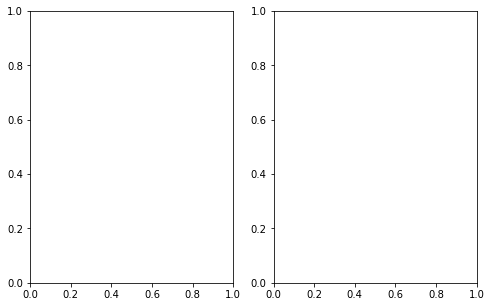

In [140]:
fig,axx=plt.subplots(1,2,figsize=(8,5))
### training loop
epoch_number = 0
EPOCHS = 20
best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch_2D(epoch_number, writer)
    
    # We don't need gradients on to do reporting
    model.train(False)

#     # evaluate model: turn off dropouts and batch normalization
#     model.eval()
    
    running_vloss = 0.0
    precip_pred=0.0
    precip_truth=0.0
    precip_pred_2mom=0.0
    precip_truth_2mom=0.0
    
    ctr=0
    for i, vdata in enumerate(val_loader):
        vinputs, vtruth = vdata
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vtruth)
        running_vloss += vloss
        precip_pred+=voutputs.sum()
        precip_truth+=vtruth.sum()
        
        ### condition on std. deviation.
        precip_pred_2mom+=torch.pow(voutputs,2).sum()
        precip_truth_2mom+=torch.pow(vtruth,2).sum()
        
        ctr+=list(voutputs.size())[0]
        
    avg_precip_pred = precip_pred*prc_norm['normalizer'] / ctr
    avg_precip_truth = precip_truth*prc_norm['normalizer'] / ctr
    avg_vloss=abs(avg_precip_pred-avg_precip_truth)
    
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
    print('Avg. precip: truth {} predict {}'.format(avg_precip_truth, avg_precip_pred))
    
    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss*prc_norm['normalizer']*24, 
                     'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
#         model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), path)

#     print("max_precip:{} mm/h".format(voutputs*prc_norm['normalizer'].max()))
#     axx[0].scatter(vinputs.detach()[:,0],(voutputs.detach())*prc_norm['normalizer'])
#     axx[1].scatter(epoch_number,avg_loss,color='black')
#     ax2=axx[1].twinx()
#     ax2.scatter(epoch_number,avg_vloss.detach()*24,color='blue')
    
#     plt.show()
        
    epoch_number += 1
    

In [141]:
torch.load(path).keys()

odict_keys(['layer1.weight', 'layer1.bias', 'layer2.weight', 'layer2.bias', 'layer3.weight', 'layer3.bias', 'layer4.weight', 'layer4.bias', 'layer5.weight', 'layer5.bias', 'layer6.weight', 'layer6.bias'])

In [142]:
model

NeuralNetwork_2D(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer1): Linear(in_features=54, out_features=256, bias=True)
  (layer2): Linear(in_features=256, out_features=256, bias=True)
  (layer3): Linear(in_features=256, out_features=256, bias=True)
  (layer4): Linear(in_features=256, out_features=256, bias=True)
  (layer5): Linear(in_features=256, out_features=256, bias=True)
  (layer6): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [143]:
for key in torch.load(path).keys():
    print(key,torch.load(path)[key].shape)

layer1.weight torch.Size([256, 54])
layer1.bias torch.Size([256])
layer2.weight torch.Size([256, 256])
layer2.bias torch.Size([256])
layer3.weight torch.Size([256, 256])
layer3.bias torch.Size([256])
layer4.weight torch.Size([256, 256])
layer4.bias torch.Size([256])
layer5.weight torch.Size([256, 256])
layer5.bias torch.Size([256])
layer6.weight torch.Size([1, 256])
layer6.bias torch.Size([1])


In [156]:
model.load_state_dict(torch.load(path))
model.eval()

NeuralNetwork_2D(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer1): Linear(in_features=54, out_features=256, bias=True)
  (layer2): Linear(in_features=256, out_features=256, bias=True)
  (layer3): Linear(in_features=256, out_features=256, bias=True)
  (layer4): Linear(in_features=256, out_features=256, bias=True)
  (layer5): Linear(in_features=256, out_features=256, bias=True)
  (layer6): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [157]:
### Predict

In [162]:
date=dt.datetime(2016,1,2)
fil='/neelin2020/ERA-5_Tq_ps/hourly/npz_files/Tq_prc_matched_{}.npz'.format(date.strftime("%Y_%m_%d"))
f=np.load(fil,'r')
prc_test=f['prc_ocn']
T_test=f['T_ocn'].T  # have time variable first
q_test=f['q_ocn'].T

# T_test=T_test[:,lev_indx:]
# q_test=q_test[:,lev_indx:]

f.close()

fil1='/neelin2020/ML_input/era5_condensed_thermo1_{}.npz'.format(date.strftime("%Y_%m_%d"))
f=np.load(fil1,'r')
crh_test=f['crh_ocn']

In [163]:
x1=(q_test-sphum_norm['xbar'])/sphum_norm['normalizer']
x2=(T_test-Temp_norm['xbar'])/Temp_norm['normalizer']

# prc_predicted=prc_predicted.detach().numpy().squeeze()

In [164]:
x=np.hstack((x1,x2))

In [165]:
prc_predicted=model(torch.from_numpy(x).float().unsqueeze(1))*prc_norm['normalizer']

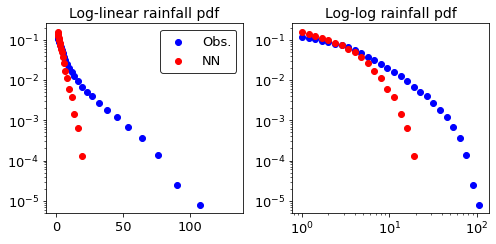

In [166]:
pcp_bins=2**(np.arange(0,8.0,0.25))

pcp_pred_hist=np.histogram(prc_predicted.detach(),bins=pcp_bins)
pcp_test_hist=np.histogram(prc_test,bins=pcp_bins)

fig,axx=plt.subplots(1,2,figsize=(7,3.5))

ax=axx[0]
ax.scatter(pcp_bins[:-1],pcp_test_hist[0]/(pcp_test_hist[0].sum()),c='blue',label='Obs.')
ax.scatter(pcp_bins[:-1],pcp_pred_hist[0]/(pcp_pred_hist[0].sum()),c='red',label='NN')

ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlim(right=1.4e2)
# ax.set_ylim(bottom=1e-10)
ax.tick_params(which='both',labelsize=13)
ax.legend(fontsize=13).get_frame().set_edgecolor('black')
ax.set_title('Log-linear rainfall pdf',fontsize=14)

ax=axx[1]
ax.scatter(pcp_bins[:-1],pcp_test_hist[0]/(pcp_test_hist[0].sum()),c='blue')
ax.scatter(pcp_bins[:-1],pcp_pred_hist[0]/(pcp_pred_hist[0].sum()),c='red')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(right=1.4e2)
# ax.set_ylim(bottom=1e-10)
ax.tick_params(which='both',labelsize=13)
ax.set_title('Log-log rainfall pdf',fontsize=14)

plt.tight_layout()
SAVE=False
if SAVE:
    plt.savefig('/home/fiaz/ML/plots/rainfall_pdfs_vertTq_input.pdf',
               format='pdf',bbox_inches='tight',dpi=125)

### P-crh relationship ###

In [167]:
crh_bins=np.arange(0,1.05,.05)

def bin_prc_crh(prc,crh,
                crh_bins,pcp_bins):
    
    crh_index=np.int_((crh-crh_bins[0])/np.diff(crh_bins)[0])
    pcp_crh_joint_pdf=np.zeros((crh_bins.size,pcp_bins.size-1))
    pcp_crh_binned=np.zeros((crh_bins.size))
    for i,j in enumerate(crh_bins):
        indx=np.where(crh_index==i)[0]
        pcp_crh_joint_pdf[i,:]=np.histogram(prc[indx],bins=pcp_bins)[0]
        pcp_crh_binned[i]=prc[indx].mean()
        
    return pcp_crh_binned,pcp_crh_joint_pdf



In [168]:
pcp_crh_binned_pred,pcp_crh_joint_pdf_pred=bin_prc_crh(prc_predicted.detach(),
                                                       crh_test,crh_bins,pcp_bins)
pcp_crh_binned,pcp_crh_joint_pdf=bin_prc_crh(prc_test,
                                                       crh_test,crh_bins,pcp_bins)

/tmp/ipykernel_12623/3542305262.py:12: RuntimeWarning: Mean of empty slice.
  pcp_crh_binned[i]=prc[indx].mean()
/home/fiaz/anaconda3/envs/ML/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/tmp/ipykernel_12623/3212619227.py:17: RuntimeWarning: divide by zero encountered in log10
  np.log10(pcp_crh_joint_pdf_pred).T,cmap=plt.get_cmap('YlOrRd'))
/tmp/ipykernel_12623/3212619227.py:25: RuntimeWarning: divide by zero encountered in log10
  np.log10(pcp_crh_joint_pdf).T,cmap=plt.get_cmap('YlOrRd'))


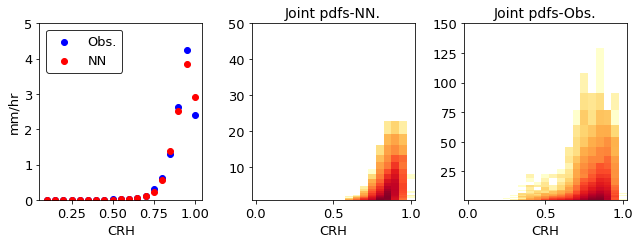

In [169]:
fig,axx=plt.subplots(1,3,figsize=(9,3.5))

ax=axx[0]
ax.scatter(crh_bins,pcp_crh_binned,c='blue',label='Obs.')
ax.scatter(crh_bins,pcp_crh_binned_pred,c='red',label='NN')

ax.set_ylim(bottom=0,top=5)
ax.tick_params(which='both',labelsize=13)

ax.legend(fontsize=13).get_frame().set_edgecolor('black')
ax.set_xlabel('CRH',fontsize=13)
ax.set_ylabel('mm/hr',fontsize=13)


ax=axx[1]
ax.pcolormesh(crh_bins,0.5*(pcp_bins[1:]+pcp_bins[:-1]),
             np.log10(pcp_crh_joint_pdf_pred).T,cmap=plt.get_cmap('YlOrRd'))
ax.tick_params(which='both',labelsize=13)
ax.set_ylim(top=50)
ax.set_xlabel('CRH',fontsize=13)
ax.set_title('Joint pdfs-NN.',fontsize=14)

ax=axx[2]
ax.pcolormesh(crh_bins,0.5*(pcp_bins[1:]+pcp_bins[:-1]),
             np.log10(pcp_crh_joint_pdf).T,cmap=plt.get_cmap('YlOrRd'))
ax.tick_params(which='both',labelsize=13)
ax.set_ylim(top=150)
ax.set_xlabel('CRH',fontsize=13)
ax.set_title('Joint pdfs-Obs.',fontsize=14)
plt.tight_layout()
dirp='/home/fiaz/ML/plots/'
SAVE=False
if SAVE:
    plt.savefig(dirp+'precip_NN_stats_500hPa_UT_vertTq.pdf',dpi=125,bbox_inches='tight')


A decent portion of the precipitation variability can be obtained from just the vertical structure of T and q.

Can we reproduce the observed mean and precip. variability? (Maps).